# Problem Set 1 Question 1b

We extract out the utilities provided from the problem set here

In [1]:
import matplotlib.pyplot as plt
import numpy as np


def add_intercept(x):
    """Add intercept to matrix x.

    Args:
        x: 2D NumPy array.

    Returns:
        New matrix same as x with 1's in the 0th column.
    """
    new_x = np.zeros((x.shape[0], x.shape[1] + 1), dtype=x.dtype)
    new_x[:, 0] = 1
    new_x[:, 1:] = x

    return new_x


def load_dataset(csv_path, label_col='y', add_intercept=False):
    """Load dataset from a CSV file.

    Args:
         csv_path: Path to CSV file containing dataset.
         label_col: Name of column to use as labels (should be 'y' or 'l').
         add_intercept: Add an intercept entry to x-values.

    Returns:
        xs: Numpy array of x-values (inputs).
        ys: Numpy array of y-values (labels).
    """

    def add_intercept_fn(x):
        global add_intercept
        return add_intercept(x)

    # Validate label_col argument
    allowed_label_cols = ('y', 't')
    if label_col not in allowed_label_cols:
        raise ValueError('Invalid label_col: {} (expected {})'
                         .format(label_col, allowed_label_cols))

    # Load headers
    with open(csv_path, 'r') as csv_fh:
        headers = csv_fh.readline().strip().split(',')

    # Load features and labels
    x_cols = [i for i in range(len(headers)) if headers[i].startswith('x')]
    l_cols = [i for i in range(len(headers)) if headers[i] == label_col]
    inputs = np.loadtxt(csv_path, delimiter=',', skiprows=1, usecols=x_cols)
    labels = np.loadtxt(csv_path, delimiter=',', skiprows=1, usecols=l_cols)

    if inputs.ndim == 1:
        inputs = np.expand_dims(inputs, -1)

    if add_intercept:
        inputs = add_intercept_fn(inputs)

    return inputs, labels


def plot(x, y, theta, save_path=None, correction=1.0):
    """Plot dataset and fitted logistic regression parameters.
    Args:
        x: Matrix of training examples, one per row.
        y: Vector of labels in {0, 1}.
        theta: Vector of parameters for logistic regression model.
        save_path: Path to save the plot.
        correction: Correction factor to apply (Problem 2(e) only).
    """
    # Plot dataset
    plt.figure()
    plt.plot(x[y == 1, -2], x[y == 1, -1], 'bx', linewidth=2)
    plt.plot(x[y == 0, -2], x[y == 0, -1], 'go', linewidth=2)

    # Plot decision boundary (found by solving for theta^T x = 0)
    margin1 = (max(x[:, -2]) - min(x[:, -2]))*0.2
    margin2 = (max(x[:, -1]) - min(x[:, -1]))*0.2
    x1 = np.arange(min(x[:, -2])-margin1, max(x[:, -2])+margin1, 0.01)
    x2 = -(theta[0] / theta[2] * correction + theta[1] / theta[2] * x1)
    plt.plot(x1, x2, c='red', linewidth=2)
    plt.xlim(x[:, -2].min()-margin1, x[:, -2].max()+margin1)
    plt.ylim(x[:, -1].min()-margin2, x[:, -1].max()+margin2)

    # Add labels and save to disk
    plt.xlabel('x1')
    plt.ylabel('x2')
    if save_path is not None:
        plt.savefig(save_path)


In [2]:
class LinearModel(object):
    """Base class for linear models."""

    def __init__(self, step_size=0.2, max_iter=100, eps=1e-5,
                 theta_0=None, verbose=True):
        """
        Args:
            step_size: Step size for iterative solvers only.
            max_iter: Maximum number of iterations for the solver.
            eps: Threshold for determining convergence.
            theta_0: Initial guess for theta. If None, use the zero vector.
            verbose: Print loss values during training.
        """
        self.theta = theta_0
        self.step_size = step_size
        self.max_iter = max_iter
        self.eps = eps
        self.verbose = verbose

    def fit(self, x, y):
        """Run solver to fit linear model.

        Args:
            x: Training example inputs. Shape (m, n).
            y: Training example labels. Shape (m,).
        """
        raise NotImplementedError('Subclass of LinearModel must implement fit method.')

    def predict(self, x):
        """Make a prediction given new inputs x.

        Args:
            x: Inputs of shape (m, n).

        Returns:
            Outputs of shape (m,).
        """
        raise NotImplementedError('Subclass of LinearModel must implement predict method.')


Let's visualise the data we are working with for logistic regression

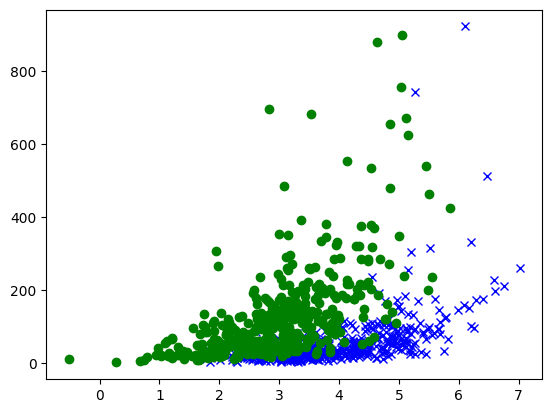

In [3]:
x2, y2 = load_dataset("_data/ds1_train.csv", add_intercept=True)
plt.figure()
plt.plot(x2[y2 == 1, -2], x2[y2 == 1, -1], 'bx', linewidth=2)
plt.plot(x2[y2 == 0, -2], x2[y2 == 0, -1], 'go', linewidth=2)

## Coding the Main `LogisticRegression` Model

Goal: We want to use Newton's method to train a Logistic Regression Model to predict given some data. We need to implement the following methods:
1. `fit(x, y)`: Train the model given training data `x` and labelled outputs `y`
2. `predict(x)`: Given inputs `x`, predict `y`

### Newton's Method

Recall that for Newton's method, we should use the following:

$$
\theta^{(i + 1)} \coloneqq \theta^{(i)} + H^{-1} \nabla_\theta \mathcal{l}(\theta)
$$
- $l$ is our likelihood that we are trying to maximise
- $H$ is our Hessian

We saw in part 1(a) that:

$$
\begin{align*}
h_\theta(x^{(i)}) &= \frac{1}{1 + \exp(-\theta^T x^{(i)})}\\
J(\theta) &= -\frac{1}{m} \sum_{i=1}^{m} y^{(i)} \log(h_\theta(x^{(i)})) + (1 - y^{(i)}) \log(1 - h_\theta(x^{(i)})) \\
\nabla_\theta J(\theta) &= -\frac{1}{m} \sum_{i = 1}^{m} (y^{(i)} - h_\theta(x^{(i)})) x^{(i)} \\
\nabla_\theta^2 J(\theta) &= \frac{1}{m} \sum_{i = 1}^{m} h_\theta(x^{(i)})(1 - h_\theta(x^{(i)})) x^{(i)} (x^{(i)})^T
\end{align*}
$$

However, now we would like to work with a design matrix $X = \begin{bmatrix} (x^{(1)})^T \\ \vdots \\ (x^{(m)})^T \end{bmatrix} \in \mathbb{R}^{m \times d}$ and $y \in \mathbb{R}^m$. These formulas are now rewritten as:

$$
h = h_\theta(X) = \sigma(X \theta) = \frac{1}{1 + \exp(-X \theta)} \in \mathbb{R}^m
$$
- $\theta^T x$ is now $X \theta$.
- $\frac{1}{1 + \exp(-X \theta)} \in \mathbb{R}^m$ is an element-wise operation now, giving 1 row per entry in $X$.

$$
J(\theta) = -\frac{1}{m} (y^T \log h + (1 - y)^T \log(1 - h)) \in \mathbb{R}
$$
- $y^T \log(h)$ sums over all examples automatically.

$$
\nabla_\theta J(\theta) = \frac{1}{m} X^T (h - y) \in \mathbb{R}^d
$$
- Each column of $X^T$ corresponds to a feature.
- $h - y \in \mathbb{R}^m$ is the vector of errors for all samples.
- Multiplying $X^T$ by $h - y$ sums the contributions of each feature across all examples.

$$
\nabla_\theta^2 J(\theta) = \frac{1}{m} X^T \text{diag}(h \odot (1 - h)) X \in \mathbb{R}^{d \times d}
$$
- We define the diagonal matrix of variances $\text{diag}(h \odot (1 - h))$, where $h \odot (1 - h)$ is element-wise multiplication (Hadamard product).


In [4]:
def main_logreg(train_path, eval_path, pred_path):
    """Problem 1(b): Logistic regression with Newton's Method.

    Args:
        train_path: Path to CSV file containing dataset for training.
        eval_path: Path to CSV file containing dataset for evaluation.
        pred_path: Path to save predictions.
    """
    x_train, y_train = load_dataset(train_path, add_intercept=True)

    # *** START CODE HERE ***
    model = LogisticRegression() # Create the LogisticRegression instance
    model.fit(x_train, y_train) # Fit the model to the training data

    plot(x_train, y_train, model.theta)

    x_test, y_test = load_dataset(eval_path, add_intercept=True) # Load evaluation dataset
    plot(x_test, y_test, model.theta)
    predictions = model.predict(x_test) # Make predictions on the evaluation dataset
    predictions = [0 if i < 0.5 else 1 for i in predictions]

    correct = 0
    wrong = 0
    for i in range(len(y_test)):
        if y_test[i] == predictions[i]:
            correct += 1
        else:
            wrong += 1

    print("Logistic Regression Results:")
    print(f"Correct: {correct}, wrong: {wrong}")

    np.savetxt(pred_path, predictions, delimiter=',', fmt="%d") # Save predictions
    # *** END CODE HERE ***


class LogisticRegression(LinearModel):
    """Logistic regression with Newton's Method as the solver.

    Example usage:
        > clf = LogisticRegression()
        > clf.fit(x_train, y_train)
        > clf.predict(x_eval)
    """

    def fit(self, x, y):
        """Run Newton's Method to minimize J(theta) for logistic regression.

        Args:
            x: Training example inputs. Shape (m, n).
            y: Training example labels. Shape (m,).
        """
        # *** START CODE HERE ***
        if self.theta is None:
            self.theta = np.zeros(x.shape[1])

        num_iterations = 0
        while True:
            num_iterations += 1
            if num_iterations >= self.max_iter:
                break

            predictions = self.predict(x)
            # J'(Theta) = 1/m X^T . (h - y)
            first_derivative = 1 / x.shape[0] * x.T.dot(predictions - y)
            # J''(Theta) = 1 / m X^T R X, R = diag(h * (1 - h)) (Hadamard product between h and (1 - h))
            second_derivative = 1 / x.shape[0] * (predictions * (1 - predictions) * x.T).dot(x)

            updated_theta = self.theta - np.linalg.inv(second_derivative).dot(first_derivative)
            if np.linalg.norm(self.theta - updated_theta, ord=1) < self.eps: # Check L1 norm
                break

            self.theta = updated_theta
        # *** END CODE HERE ***

    def predict(self, x):
        """Make a prediction given new inputs x.

        Args:
            x: Inputs of shape (m, n).

        Returns:
            Outputs of shape (m,).
        """
        # *** START CODE HERE ***
        if self.theta is None:
            self.theta = np.zeros(x.shape[1])

        # h(x) = 1/(1 + exp(- X Theta ))
        return 1 / (1 + np.exp(-x.dot(self.theta)))
        # *** END CODE HERE ***

Logistic Regression Results:
Correct: 90, wrong: 10


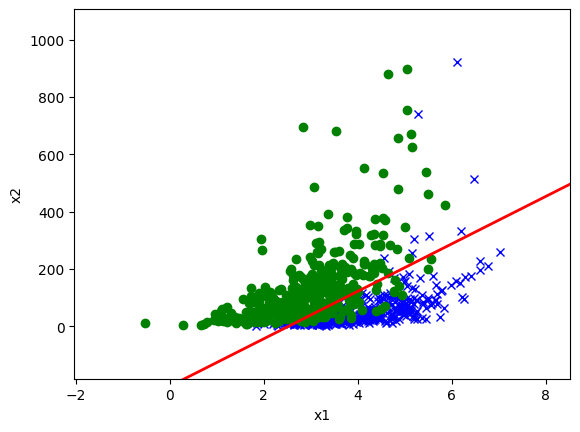

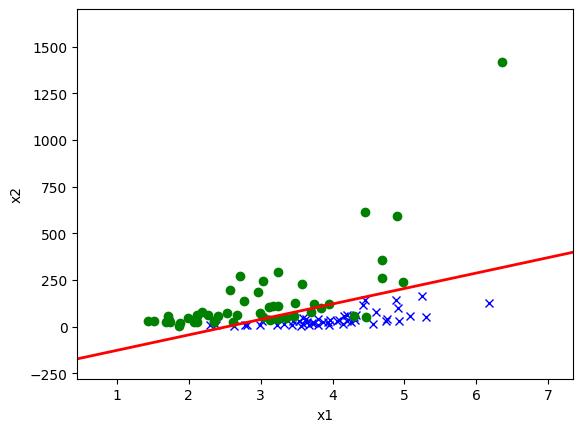

In [5]:
main_logreg("_data/ds1_train.csv", "_data/ds1_valid.csv", "_data/ds1_pred.csv")

# Problem Set 1 Question 1e

From the previous part, we saw how to calculate $\phi, \mu_0, \mu_1, \Sigma$:

$$
\begin{cases}
    \phi &= \frac{1}{m} \sum_{i=1}^m 1\{y^{(i)} = 1\} \\
    \mu_0 &= \frac{\sum_{i=1}^m 1\{y^{(i)} = 0\}x^{(i)}}{\sum_{i=1}^m 1\{y^{(i)} = 0\}} \\
    \mu_1 &= \frac{\sum_{i=1}^m 1\{y^{(i)} = 1\}x^{(i)}}{\sum_{i=1}^m 1\{y^{(i)} = 1\}} \\
    \Sigma &= \frac{1}{m} \sum_{i=1}^m (x^{(i)} - \mu_{y^{(i)}}) (x^{(i)} - \mu_{y^{(i)}})^T
\end{cases}
$$

We also saw, to predict the classification for some input $x$:

$$
P(y = 1 \mid x; \theta) = \frac{1}{1 + \exp \left( -(\theta^T x + \theta_0) \right)}
$$

where

$$
\begin{align*}
\theta &= \Sigma^{-1} (\mu_1 - \mu_0) \\
\theta_0 &= \frac{1}{2} \mu_0^T \Sigma^{-1} \mu_0 - \frac{1}{2} \mu_1^T \Sigma^{-1} \mu_1 + \log \frac{\phi}{1 - \phi}
\end{align*}
$$

In [6]:
def main_gda(train_path, eval_path, pred_path):
    x_train, y_train = load_dataset(train_path, add_intercept=False)

    # *** START CODE HERE ***
    clf = GDA()
    clf.fit(x_train, y_train)

    x_eval, y_eval = load_dataset(eval_path, add_intercept=False)
    y_predict = clf.predict(x_eval)
    y_predict = [0 if i < 0.5 else 1 for i in y_predict]

    correct = 0
    wrong = 0
    for i in range(len(y_eval)):
        if y_eval[i] == y_predict[i]:
            correct += 1
        else:
            wrong += 1

    print("GDA results:")
    print(f"Correct: {correct}, wrong: {wrong}")

    x_0 = x_train[y_train == 0] # Data points with label 0
    x_1 = x_train[y_train == 1] # Data points with label 1

    plt.title('GDA Train Data Visualisation')
    plt.plot(x_0[:, 0], x_0[:, 1], 'go', label='Class 0')
    plt.plot(x_1[:, 0], x_1[:, 1], 'bx', label='Class 1')

    # Calculate decision boundary
    sigma_inv = np.linalg.inv(clf.sigma)
    theta = sigma_inv.dot(clf.mu1 - clf.mu0)
    theta0 = 0.5 * clf.mu0.dot(sigma_inv).dot(clf.mu0) - 0.5 * clf.mu1.T.dot(sigma_inv).dot(clf.mu1) + np.log(clf.phi / (1 - clf.phi))

    x_vals = np.linspace(x_train[:, 0].min() - 1, x_train[:, 0].max() + 1, 100)
    y_vals = -(theta0 + theta[0] * x_vals) / theta[1]

    plt.plot(x_vals, y_vals, 'r-', label='Decision Boundary')

    plt.xlabel('x1')
    plt.ylabel('x2')

    plt.legend()

class GDA(LinearModel):
    """Gaussian Discriminant Analysis.

    Example usage:
        > clf = GDA()
        > clf.fit(x_train, y_train)
        > clf.predict(x_eval)
    """

    def fit(self, x, y):
        """Fit a GDA model to training set given by x and y.

        Args:
            x: Training example inputs. Shape (m, n).
            y: Training example labels. Shape (m,).

        Returns:
            theta: GDA model parameters.
        """
        # *** START CODE HERE ***
        self.phi = np.mean(y)
        self.mu0 = np.mean(x[y == 0], axis=0) # Select rows where y == 0, then column-wise mean
        self.mu1 = np.mean(x[y == 1], axis=0) # Select rows where y == 1, then column-wise mean

        diffs = np.zeros(x.shape)
        for i in range(x.shape[0]):
            if y[i] == 0:
                diffs[i] = x[i] - self.mu0
            else:
                diffs[i] = x[i] - self.mu1

        self.sigma = diffs.T.dot(diffs) / x.shape[0]
        # *** END CODE HERE ***

    def predict(self, x):
        """Make a prediction given new inputs x.

        Args:
            x: Inputs of shape (m, n).

        Returns:
            Outputs of shape (m,).
        """
        # *** START CODE HERE ***
        sigma_inv = np.linalg.inv(self.sigma)
        theta = sigma_inv.dot(self.mu1 - self.mu0)
        theta0 = 0.5 * self.mu0.dot(sigma_inv).dot(self.mu0) - 0.5 * self.mu1.T.dot(sigma_inv).dot(self.mu1) + np.log(self.phi / (1 - self.phi))
        
        p = 1 / (1 + np.exp(-(np.dot(x, theta) + theta0)))

        return (p >= 0.5).astype(int)
        # *** END CODE HERE

# Question 1f

For Dataset 1, create a plot of the training data with $x_1$ on the horizontal axis, and $x_2$ on the vertical axis. To visualise the two classes, use a different symbol for examples $x^{(i)}$ with $y^{(i)} = 0$ than for those with $y^{(i)} = 1$. On the same figure, plot the decision boundary found by logistic regression in part (b). Make an identical plot with the decision boundary found by GDA in part (e)

In [7]:
def compare(train_path, eval_path):
    print("Comparing Logistic Regression and GDA:")
    x, y = load_dataset(train_path, add_intercept=True)

    clf_log = LogisticRegression()
    clf_log.fit(x, y)

    plt.figure()
    plt.plot(x[y == 1, -2], x[y == 1, -1], 'bx', linewidth=2, label='Class 1')
    plt.plot(x[y == 0, -2], x[y == 0, -1], 'go', linewidth=2, label='Class 0')

    margin1 = (max(x[:, -2]) - min(x[:, -2]))*0.2
    margin2 = (max(x[:, -1]) - min(x[:, -1]))*0.2
    x1 = np.arange(min(x[:, -2])-margin1, max(x[:, -2])+margin1, 0.01)
    x2 = -(clf_log.theta[0] / clf_log.theta[2] * 1 + clf_log.theta[1] / clf_log.theta[2] * x1)
    plt.plot(x1, x2, c='red', linewidth=2, label='Logistic Regression')
    plt.xlim(x[:, -2].min()-margin1, x[:, -2].max()+margin1)
    plt.ylim(x[:, -1].min()-margin2, x[:, -1].max()+margin2)

    x_eval, y_eval = load_dataset(eval_path, add_intercept=True)
    y_predict = clf_log.predict(x_eval) # Make predictions on the evaluation dataset
    y_predict = [0 if i < 0.5 else 1 for i in y_predict]

    correct = 0
    wrong = 0
    for i in range(len(y_eval)):
        if y_eval[i] == y_predict[i]:
            correct += 1
        else:
            wrong += 1

    print("Logistic Regression Results:")
    print(f"Correct: {correct}, wrong: {wrong}")

    x, y = load_dataset(train_path, add_intercept=False)
    clf_gda = GDA()
    clf_gda.fit(x, y)

    sigma_inv = np.linalg.inv(clf_gda.sigma)
    theta = sigma_inv.dot(clf_gda.mu1 - clf_gda.mu0)
    theta0 = 0.5 * clf_gda.mu0.dot(sigma_inv).dot(clf_gda.mu0) - 0.5 * clf_gda.mu1.T.dot(sigma_inv).dot(clf_gda.mu1) + np.log(clf_gda.phi / (1 - clf_gda.phi))

    x_vals = np.linspace(x[:, 0].min() - 1, x[:, 0].max() + 1, 100)
    y_vals = -(theta0 + theta[0] * x_vals) / theta[1]

    plt.plot(x_vals, y_vals, 'y-', label='GDA')

    plt.xlabel('x1')
    plt.ylabel('x2')
    plt.legend()

    x_eval, y_eval = load_dataset(eval_path, add_intercept=False)
    y_predict = clf_gda.predict(x_eval)
    y_predict = [0 if i < 0.5 else 1 for i in y_predict]

    plt.title('Logistic Regression vs GDA Decision Boundaries')

    correct = 0
    wrong = 0
    for i in range(len(y_eval)):
        if y_eval[i] == y_predict[i]:
            correct += 1
        else:
            wrong += 1

    print("GDA results:")
    print(f"Correct: {correct}, wrong: {wrong}")

Comparing Logistic Regression and GDA:
Logistic Regression Results:
Correct: 90, wrong: 10
GDA results:
Correct: 83, wrong: 17


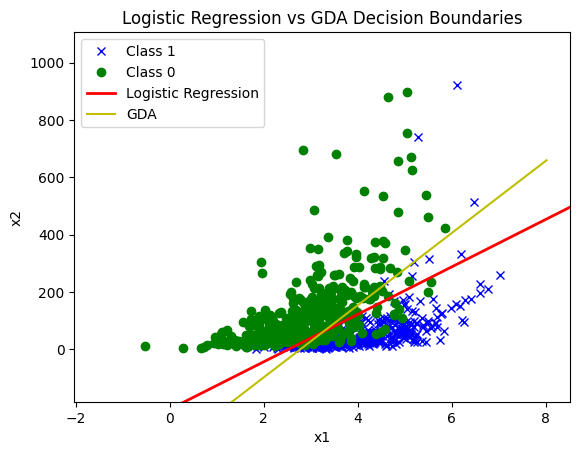

In [8]:
compare("_data/ds1_train.csv", "_data/ds1_valid.csv")

# Question 1g

Repeat the steps in part (f) for Dataset 2. On which dataset does GDA seem to perform worse than logistic regression? Why might this be the case?

Comparing Logistic Regression and GDA:
Logistic Regression Results:
Correct: 91, wrong: 9
GDA results:
Correct: 91, wrong: 9


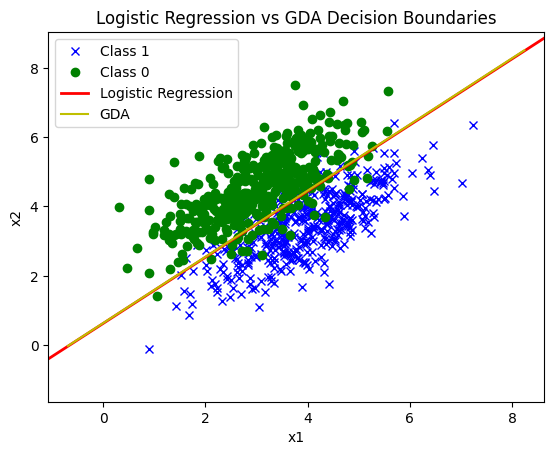

In [9]:
compare("_data/ds2_train.csv", "_data/ds2_valid.csv")

In [10]:
def plot_feature_distributions(path):
    x, y = load_dataset(path, add_intercept=False)
    n_features = x.shape[1]
    fig, axes = plt.subplots(1, n_features, figsize=(5 * n_features, 4))
    fig.suptitle(f'Feature Distributions for {path}')

    if n_features == 1:
        axes = [axes]  # make iterable if only 1D

    for i in range(n_features):
        axes[i].hist(x[y==0, i], bins=20, alpha=0.5, label="y=0", color="red", density=True)
        axes[i].hist(x[y==1, i], bins=20, alpha=0.5, label="y=1", color="blue", density=True)
        axes[i].set_title(f"Feature {i+1}")
        axes[i].legend()

    plt.tight_layout()
    plt.show()

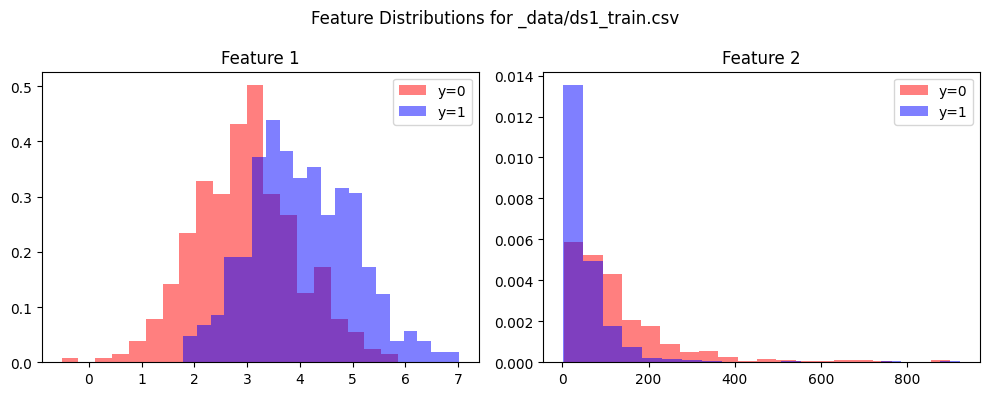

In [11]:
plot_feature_distributions("_data/ds1_train.csv")

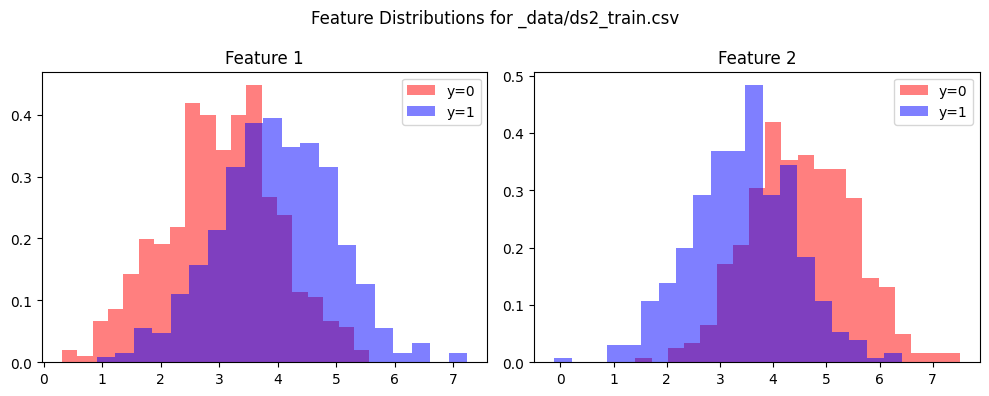

In [12]:
plot_feature_distributions("_data/ds2_train.csv")

In dataset 1, GDA performed worse, because not all the features are normally distributed

# Question 1h

For the dataset where GDA performed worse in parts (f) and (g), can you find a transformation of $x^{(i)}$'s such that GDA performs significantly better? What is this transformation?

c:\Users\thx\Desktop\Programming\astro-blog\venv\Lib\site-packages\sklearn\preprocessing\_data.py:2846: UserWarning: n_quantiles (1000) is greater than the total number of samples (800). n_quantiles is set to n_samples.
  warnings.warn(


GDA results:
Correct: 93, wrong: 7


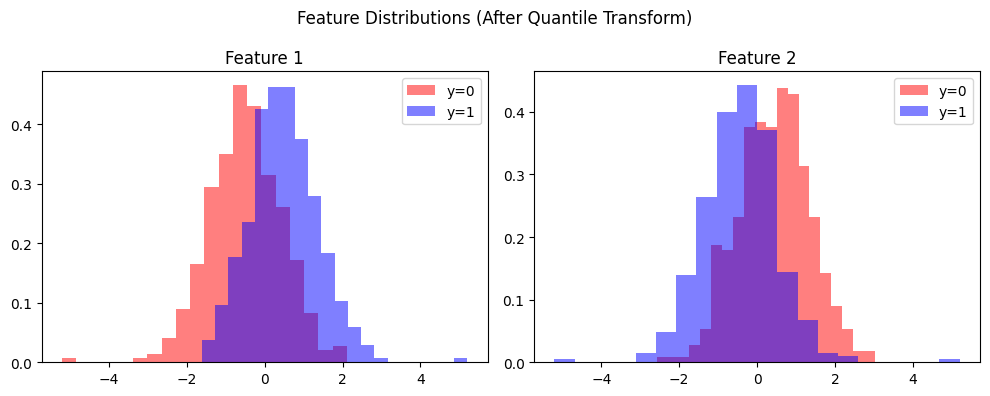

In [20]:
from sklearn.preprocessing import QuantileTransformer

x_trans, y = load_dataset("_data/ds1_train.csv", add_intercept=False)
transformer = QuantileTransformer(output_distribution='normal', random_state=42)
x_trans = transformer.fit_transform(x_trans)

clf = GDA()
clf.fit(x_trans, y)

x_eval, y_eval = load_dataset("_data/ds1_valid.csv", add_intercept=False)
x_eval_trans = transformer.transform(x_eval)
y_predict = clf.predict(x_eval_trans)
y_predict = [0 if i < 0.5 else 1 for i in y_predict]

correct = 0
wrong = 0
for i in range(len(y_eval)):
    if y_eval[i] == y_predict[i]:
        correct += 1
    else:
        wrong += 1

print("GDA results:")
print(f"Correct: {correct}, wrong: {wrong}")

n_features = x_trans.shape[1]
fig, axes = plt.subplots(1, n_features, figsize=(5 * n_features, 4))
fig.suptitle(f'Feature Distributions (After Quantile Transform)')

if n_features == 1:
    axes = [axes]  # make iterable if only 1D

for i in range(n_features):
    axes[i].hist(x_trans[y==0, i], bins=20, alpha=0.5, label="y=0", color="red", density=True)
    axes[i].hist(x_trans[y==1, i], bins=20, alpha=0.5, label="y=1", color="blue", density=True)
    axes[i].set_title(f"Feature {i+1}")
    axes[i].legend()

plt.tight_layout()
plt.show()

GDA results:
Correct: 92, wrong: 8


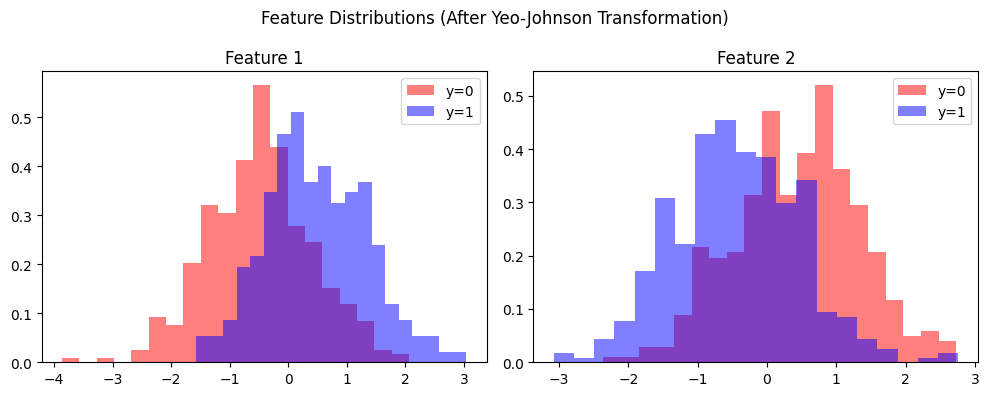

In [21]:
from sklearn.preprocessing import PowerTransformer

x_trans, y = load_dataset("_data/ds1_train.csv", add_intercept=False)
transformer = PowerTransformer(method='yeo-johnson')
x_trans = transformer.fit_transform(x_trans)

clf = GDA()
clf.fit(x_trans, y)

x_eval, y_eval = load_dataset("_data/ds1_valid.csv", add_intercept=False)
x_eval_trans = transformer.transform(x_eval)
y_predict = clf.predict(x_eval_trans)
y_predict = [0 if i < 0.5 else 1 for i in y_predict]

correct = 0
wrong = 0
for i in range(len(y_eval)):
    if y_eval[i] == y_predict[i]:
        correct += 1
    else:
        wrong += 1

print("GDA results:")
print(f"Correct: {correct}, wrong: {wrong}")

n_features = x_trans.shape[1]
fig, axes = plt.subplots(1, n_features, figsize=(5 * n_features, 4))
fig.suptitle(f'Feature Distributions (After Yeo-Johnson Transformation)')

if n_features == 1:
    axes = [axes]  # make iterable if only 1D

for i in range(n_features):
    axes[i].hist(x_trans[y==0, i], bins=20, alpha=0.5, label="y=0", color="red", density=True)
    axes[i].hist(x_trans[y==1, i], bins=20, alpha=0.5, label="y=1", color="blue", density=True)
    axes[i].set_title(f"Feature {i+1}")
    axes[i].legend()

plt.tight_layout()
plt.show()

We can use a rank-based/quantile transformation (e.g. `QuantileTransformer`) to reshape the empirical distribution into a Gaussian-like distribution. This way, GDA can perform better. 

We cannot use Box-Cox because Box-Cox requires strictly positive values, and we have data in our training which is not positive. However, we can use Yeo-Johnson transformation, which is a generalisation of Box-Cox, which works for both positive and negative values